In [1]:
import torch
import torchvision
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import utils
import numpy as np
import os
from collections import defaultdict
import pickle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

c:\Users\afxwo\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

In [4]:
last_activations = []
def get_last_layer_activation(module, input, output):
    last_activations.append(output)

# ML Model Code

## Resnet

### Edit Model for Last Layer Hook

In [5]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

In [6]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# resnet18.layer4[1]
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
# resnet18.layer4[1].register_forward_hook(get_last_layer_activation)
resnet18.fc.register_forward_hook(get_last_layer_activation)

### Run Inference

In [14]:
pkl12path = 'mappings/exhaustive_mapping_12.pkl'
pkl12 = utils.load_dict(pkl12path)
similaritiesdict = defaultdict(list)
last_activations = []

In [15]:
folpath = 'exhaustive_generated_set\\12'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if not 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl12[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                resnet18(imgin)
                resnet18(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['reversal']-------------------


['reversal']: 100%|██████████| 4094/4094 [01:18<00:00, 52.21it/s]


-------------Running ['mirror']-------------------


['mirror']: 100%|██████████| 4094/4094 [01:17<00:00, 52.55it/s]


-------------Running ['randomphasic']-------------------


['randomphasic']: 100%|██████████| 4094/4094 [01:19<00:00, 51.52it/s]


-------------Running ['randomdelete']-------------------


['randomdelete']: 100%|██████████| 4094/4094 [01:19<00:00, 51.65it/s]


-------------Running ['reversal', 'mirror']-------------------


['reversal', 'mirror']: 100%|██████████| 4094/4094 [01:25<00:00, 47.93it/s]


-------------Running ['randomdelete', 'mirror']-------------------


['randomdelete', 'mirror']: 100%|██████████| 4094/4094 [01:48<00:00, 37.65it/s]


-------------Running ['reversal', 'randomphasic']-------------------


['reversal', 'randomphasic']: 100%|██████████| 4094/4094 [01:37<00:00, 42.09it/s]


-------------Running ['randomdelete', 'reversal', 'randomphasic']-------------------


['randomdelete', 'reversal', 'randomphasic']: 100%|██████████| 4094/4094 [01:25<00:00, 47.91it/s]


-------------Running ['randomdelete', 'reversal', 'mirror']-------------------


['randomdelete', 'reversal', 'mirror']: 100%|██████████| 4094/4094 [01:56<00:00, 35.16it/s]


In [16]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_12
with open(f'similarities/exhaustive/resnet/filled.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [17]:
pkl11path = 'mappings/exhaustive_mapping_11.pkl'
pkl11 = utils.load_dict(pkl11path)
similaritiesdict = defaultdict(list)
last_activations = []

In [18]:
folpath = 'exhaustive_generated_set\\11'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl11[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                resnet18(imgin)
                resnet18(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 2046/2046 [00:38<00:00, 52.49it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 2046/2046 [00:39<00:00, 51.31it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 2046/2046 [00:38<00:00, 52.63it/s]


In [19]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_11
with open(f'similarities/exhaustive/resnet/unfilled11.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [20]:
pkl10path = 'mappings/exhaustive_mapping_10.pkl'
pkl10 = utils.load_dict(pkl10path)
similaritiesdict = defaultdict(list)
last_activations = []

In [21]:
folpath = 'exhaustive_generated_set\\10'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl10[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                resnet18(imgin)
                resnet18(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 1022/1022 [02:30<00:00,  6.78it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 1022/1022 [00:26<00:00, 39.28it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 1022/1022 [00:22<00:00, 46.31it/s]


In [22]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_10
with open(f'similarities/exhaustive/resnet/unfilled10.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [81]:
similaritiesdict = defaultdict(list)
last_activations = []
for _ in tqdm(range(1000)):
    l1 = utils.random_binary_list()
    l2 = utils.random_binary_list()
    img1 = utils.array2img(l1, num_circles=len(l1), radius=0.75)
    img2 = utils.array2img(l2, num_circles=len(l2), radius=0.75)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        resnet18(img1)
        resnet18(img2)
    assert len(last_activations) == 2
    tensin = last_activations[0].flatten().unsqueeze(0)
    tensout = last_activations[1].flatten().unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
    similaritiesdict['ResNet18'].append(sim)
    last_activations = []
with open(f'similarities/exhaustive/resnet/random.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

100%|██████████| 1000/1000 [00:34<00:00, 28.82it/s]


## VGG

### Hook Final Activation Layer

In [24]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)

In [25]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [27]:
vgg16.classifier[6].register_forward_hook(get_last_layer_activation)

### Run Inference

In [28]:
pkl12path = 'mappings/exhaustive_mapping_12.pkl'
pkl12 = utils.load_dict(pkl12path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\12'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if not 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl12[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                vgg16(imgin)
                vgg16(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['reversal']-------------------


['reversal']: 100%|██████████| 4094/4094 [01:59<00:00, 34.38it/s]


-------------Running ['mirror']-------------------


['mirror']: 100%|██████████| 4094/4094 [02:04<00:00, 32.80it/s]


-------------Running ['randomphasic']-------------------


['randomphasic']: 100%|██████████| 4094/4094 [01:57<00:00, 34.81it/s]


-------------Running ['randomdelete']-------------------


['randomdelete']: 100%|██████████| 4094/4094 [01:59<00:00, 34.27it/s]


-------------Running ['reversal', 'mirror']-------------------


['reversal', 'mirror']: 100%|██████████| 4094/4094 [02:05<00:00, 32.56it/s]


-------------Running ['randomdelete', 'mirror']-------------------


['randomdelete', 'mirror']: 100%|██████████| 4094/4094 [02:06<00:00, 32.32it/s]


-------------Running ['reversal', 'randomphasic']-------------------


['reversal', 'randomphasic']: 100%|██████████| 4094/4094 [02:26<00:00, 27.93it/s]


-------------Running ['randomdelete', 'reversal', 'randomphasic']-------------------


['randomdelete', 'reversal', 'randomphasic']: 100%|██████████| 4094/4094 [02:37<00:00, 25.91it/s]


-------------Running ['randomdelete', 'reversal', 'mirror']-------------------


['randomdelete', 'reversal', 'mirror']: 100%|██████████| 4094/4094 [03:06<00:00, 21.98it/s]  


In [29]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_12
with open(f'similarities/exhaustive/vgg/filled.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [30]:
pkl11path = 'mappings/exhaustive_mapping_11.pkl'
pkl11 = utils.load_dict(pkl11path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\11'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl11[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                vgg16(imgin)
                vgg16(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 2046/2046 [01:31<00:00, 22.44it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 2046/2046 [01:17<00:00, 26.52it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 2046/2046 [03:28<00:00,  9.81it/s]  


In [31]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_11
with open(f'similarities/exhaustive/vgg/unfilled11.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [32]:
pkl10path = 'mappings/exhaustive_mapping_10.pkl'
pkl10 = utils.load_dict(pkl10path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\10'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl10[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                vgg16(imgin)
                vgg16(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 1022/1022 [00:25<00:00, 39.51it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 1022/1022 [00:39<00:00, 25.80it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 1022/1022 [00:36<00:00, 27.77it/s]


In [33]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_10
with open(f'similarities/exhaustive/vgg/unfilled10.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [82]:
similaritiesdict = defaultdict(list)
last_activations = []
for _ in tqdm(range(1000)):
    l1 = utils.random_binary_list()
    l2 = utils.random_binary_list()
    img1 = utils.array2img(l1, num_circles=len(l1), radius=0.75)
    img2 = utils.array2img(l2, num_circles=len(l2), radius=0.75)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        vgg16(img1)
        vgg16(img2)
    assert len(last_activations) == 2
    tensin = last_activations[0].flatten().unsqueeze(0)
    tensout = last_activations[1].flatten().unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
    similaritiesdict['VGG16'].append(sim)
    last_activations = []
with open(f'similarities/exhaustive/vgg/random.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

100%|██████████| 1000/1000 [00:36<00:00, 27.24it/s]


## DenseNet

### Hook Final Activation Layer

In [35]:
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)

In [36]:
densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [37]:
densenet121.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [38]:
densenet121.classifier.register_forward_hook(get_last_layer_activation)

#### Run Inference

In [39]:
pkl12path = 'mappings/exhaustive_mapping_12.pkl'
pkl12 = utils.load_dict(pkl12path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\12'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if not 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
        # for filepath in os.listdir(folpath):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl12[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                densenet121(imgin)
                densenet121(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['reversal']-------------------


['reversal']: 100%|██████████| 4094/4094 [03:31<00:00, 19.39it/s]


-------------Running ['mirror']-------------------


['mirror']: 100%|██████████| 4094/4094 [04:17<00:00, 15.89it/s]


-------------Running ['randomphasic']-------------------


['randomphasic']: 100%|██████████| 4094/4094 [05:14<00:00, 13.02it/s]


-------------Running ['randomdelete']-------------------


['randomdelete']: 100%|██████████| 4094/4094 [05:20<00:00, 12.75it/s]


-------------Running ['reversal', 'mirror']-------------------


['reversal', 'mirror']: 100%|██████████| 4094/4094 [05:29<00:00, 12.41it/s]


-------------Running ['randomdelete', 'mirror']-------------------


['randomdelete', 'mirror']: 100%|██████████| 4094/4094 [05:44<00:00, 11.87it/s]  


-------------Running ['reversal', 'randomphasic']-------------------


['reversal', 'randomphasic']: 100%|██████████| 4094/4094 [06:08<00:00, 11.11it/s]


-------------Running ['randomdelete', 'reversal', 'randomphasic']-------------------


['randomdelete', 'reversal', 'randomphasic']: 100%|██████████| 4094/4094 [05:57<00:00, 11.44it/s]


-------------Running ['randomdelete', 'reversal', 'mirror']-------------------


['randomdelete', 'reversal', 'mirror']: 100%|██████████| 4094/4094 [06:21<00:00, 10.72it/s]  


In [40]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_12
with open(f'similarities/exhaustive/densenet/filled.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [41]:
pkl11path = 'mappings/exhaustive_mapping_11.pkl'
pkl11 = utils.load_dict(pkl11path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\11'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl11[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                densenet121(imgin)
                densenet121(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 2046/2046 [02:56<00:00, 11.62it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 2046/2046 [02:57<00:00, 11.56it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 2046/2046 [05:31<00:00,  6.17it/s]


In [42]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_11
with open(f'similarities/exhaustive/densenet/unfilled11.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [43]:
pkl10path = 'mappings/exhaustive_mapping_10.pkl'
pkl10 = utils.load_dict(pkl10path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\10'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl10[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                densenet121(imgin)
                densenet121(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 1022/1022 [00:48<00:00, 21.27it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 1022/1022 [01:07<00:00, 15.05it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 1022/1022 [01:02<00:00, 16.27it/s]


In [44]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_10
with open(f'similarities/exhaustive/densenet/unfilled10.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [83]:
similaritiesdict = defaultdict(list)
last_activations = []
for _ in tqdm(range(1000)):
    l1 = utils.random_binary_list()
    l2 = utils.random_binary_list()

    img1 = utils.array2img(l1, num_circles=len(l1), radius=0.75)
    img2 = utils.array2img(l2, num_circles=len(l2), radius=0.75)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        densenet121(img1)
        densenet121(img2)
    assert len(last_activations) == 2
    tensin = last_activations[0].flatten().unsqueeze(0)
    tensout = last_activations[1].flatten().unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
    similaritiesdict['DenseNet121'].append(sim)
    last_activations = []
with open(f'similarities/exhaustive/densenet/random.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

100%|██████████| 1000/1000 [01:04<00:00, 15.43it/s]


## Inception

### Hook Final Activation Layer

In [46]:
inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1).to(device)

In [47]:
inception_v3.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [48]:
inception_v3.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [49]:
inception_v3.fc.register_forward_hook(get_last_layer_activation)

### Run Inference

In [50]:
transform_inception = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((299, 299)),
        torchvision.transforms.ToTensor()
    ]
)

In [51]:
pkl12path = 'mappings/exhaustive_mapping_12.pkl'
pkl12 = utils.load_dict(pkl12path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\12'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if not 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
        # for filepath in os.listdir(folpath):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath).convert('RGB')
            imgin = transform_inception(imgin).unsqueeze(0).to(device)

            imglist = pkl12[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = Image.fromarray(utils.array2img(imglist, num_circles=len(imglist), radius=0.75)).convert('RGB')
            imgout = transform_inception(imgout).unsqueeze(0).to(device)
            # print(imgin.shape)
            with torch.no_grad():
                inception_v3(imgin)
                inception_v3(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['reversal']-------------------


['reversal']: 100%|██████████| 4094/4094 [05:05<00:00, 13.40it/s] 


-------------Running ['mirror']-------------------


['mirror']: 100%|██████████| 4094/4094 [05:38<00:00, 12.09it/s]


-------------Running ['randomphasic']-------------------


['randomphasic']: 100%|██████████| 4094/4094 [04:48<00:00, 14.17it/s]


-------------Running ['randomdelete']-------------------


['randomdelete']: 100%|██████████| 4094/4094 [05:40<00:00, 12.04it/s]


-------------Running ['reversal', 'mirror']-------------------


['reversal', 'mirror']: 100%|██████████| 4094/4094 [05:05<00:00, 13.39it/s] 


-------------Running ['randomdelete', 'mirror']-------------------


['randomdelete', 'mirror']: 100%|██████████| 4094/4094 [05:24<00:00, 12.61it/s] 


-------------Running ['reversal', 'randomphasic']-------------------


['reversal', 'randomphasic']: 100%|██████████| 4094/4094 [06:08<00:00, 11.11it/s]  


-------------Running ['randomdelete', 'reversal', 'randomphasic']-------------------


['randomdelete', 'reversal', 'randomphasic']: 100%|██████████| 4094/4094 [05:33<00:00, 12.26it/s]


-------------Running ['randomdelete', 'reversal', 'mirror']-------------------


['randomdelete', 'reversal', 'mirror']: 100%|██████████| 4094/4094 [05:56<00:00, 11.47it/s] 


In [52]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_12
with open(f'similarities/exhaustive/inception/filled.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [53]:
pkl11path = 'mappings/exhaustive_mapping_11.pkl'
pkl11 = utils.load_dict(pkl11path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\11'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
        # for filepath in os.listdir(folpath):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath).convert('RGB')
            imgin = transform_inception(imgin).unsqueeze(0).to(device)

            imglist = pkl11[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = Image.fromarray(utils.array2img(imglist, num_circles=len(imglist), radius=0.75)).convert('RGB')
            imgout = transform_inception(imgout).unsqueeze(0).to(device)
            # print(imgin.shape)
            with torch.no_grad():
                inception_v3(imgin)
                inception_v3(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 2046/2046 [03:08<00:00, 10.85it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 2046/2046 [02:39<00:00, 12.80it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 2046/2046 [05:28<00:00,  6.24it/s]  


In [54]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_11
with open(f'similarities/exhaustive/inception/unfilled11.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [55]:
pkl10path = 'mappings/exhaustive_mapping_10.pkl'
pkl10 = utils.load_dict(pkl10path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\10'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
        # for filepath in os.listdir(folpath):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath).convert('RGB')
            imgin = transform_inception(imgin).unsqueeze(0).to(device)

            imglist = pkl10[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = Image.fromarray(utils.array2img(imglist, num_circles=len(imglist), radius=0.75)).convert('RGB')
            imgout = transform_inception(imgout).unsqueeze(0).to(device)
            # print(imgin.shape)
            with torch.no_grad():
                inception_v3(imgin)
                inception_v3(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 1022/1022 [01:21<00:00, 12.48it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 1022/1022 [01:06<00:00, 15.42it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 1022/1022 [01:13<00:00, 13.92it/s]


In [56]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_10
with open(f'similarities/exhaustive/inception/unfilled10.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [84]:
similaritiesdict = defaultdict(list)
last_activations = []
for _ in tqdm(range(1000)):
    l1 = utils.random_binary_list()
    l2 = utils.random_binary_list()

    img1 = utils.array2img(l1, num_circles=len(l1), radius=0.75)
    img2 = utils.array2img(l2, num_circles=len(l2), radius=0.75)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        inception_v3(img1)
        inception_v3(img2)
    assert len(last_activations) == 2
    tensin = last_activations[0].flatten().unsqueeze(0)
    tensout = last_activations[1].flatten().unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
    similaritiesdict['InceptionV3'].append(sim)
    last_activations = []
with open(f'similarities/exhaustive/inception/random.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

100%|██████████| 1000/1000 [00:58<00:00, 17.02it/s]


## AlexNet

In [58]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)

In [59]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [60]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [61]:
alexnet.classifier[6].register_forward_hook(get_last_layer_activation)

In [62]:
pkl12path = 'mappings/exhaustive_mapping_12.pkl'
pkl12 = utils.load_dict(pkl12path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\12'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if not 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
        # for filepath in os.listdir(folpath):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl12[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                alexnet(imgin)
                alexnet(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['reversal']-------------------


['reversal']: 100%|██████████| 4094/4094 [02:01<00:00, 33.63it/s]


-------------Running ['mirror']-------------------


['mirror']: 100%|██████████| 4094/4094 [02:05<00:00, 32.73it/s]


-------------Running ['randomphasic']-------------------


['randomphasic']: 100%|██████████| 4094/4094 [02:12<00:00, 30.99it/s]


-------------Running ['randomdelete']-------------------


['randomdelete']: 100%|██████████| 4094/4094 [02:09<00:00, 31.60it/s]


-------------Running ['reversal', 'mirror']-------------------


['reversal', 'mirror']: 100%|██████████| 4094/4094 [02:07<00:00, 32.03it/s]


-------------Running ['randomdelete', 'mirror']-------------------


['randomdelete', 'mirror']: 100%|██████████| 4094/4094 [02:12<00:00, 31.00it/s]


-------------Running ['reversal', 'randomphasic']-------------------


['reversal', 'randomphasic']: 100%|██████████| 4094/4094 [02:13<00:00, 30.60it/s]


-------------Running ['randomdelete', 'reversal', 'randomphasic']-------------------


['randomdelete', 'reversal', 'randomphasic']: 100%|██████████| 4094/4094 [02:37<00:00, 26.01it/s]  


-------------Running ['randomdelete', 'reversal', 'mirror']-------------------


['randomdelete', 'reversal', 'mirror']: 100%|██████████| 4094/4094 [02:21<00:00, 28.87it/s]


In [63]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_12
with open(f'similarities/exhaustive/alexnet/filled.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [64]:
pkl11path = 'mappings/exhaustive_mapping_11.pkl'
pkl11 = utils.load_dict(pkl11path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\11'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl11[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                alexnet(imgin)
                alexnet(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 2046/2046 [03:30<00:00,  9.74it/s] 


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 2046/2046 [00:48<00:00, 41.79it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 2046/2046 [01:00<00:00, 33.81it/s]


In [65]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_11
with open(f'similarities/exhaustive/alexnet/unfilled11.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [66]:
pkl10path = 'mappings/exhaustive_mapping_10.pkl'
pkl10 = utils.load_dict(pkl10path)
similaritiesdict = defaultdict(list)
last_activations = []
folpath = 'exhaustive_generated_set\\10'
for transformation in utils.HAHN_TRANSFORMATION_COMBOS:
    if 'randominsertion' in transformation:
        print(f'-------------Running {transformation}-------------------')
        for filepath in tqdm(os.listdir(folpath), desc=f'{transformation}'):
            imgpath = os.path.join(folpath, filepath)
            imgin = Image.open(imgpath)
            imgin = transform(imgin).unsqueeze(0).to(device)

            imglist = pkl10[filepath.split('.')[0]]
            # print(imglist)
            for t in transformation:
                func = getattr(utils, t)
                imglist = func(imglist)
            # print(imglist)
            imgout = utils.array2img(imglist, num_circles=len(imglist), radius=0.75)
            imgout = transform(imgout).unsqueeze(0).to(device)

            with torch.no_grad():
                alexnet(imgin)
                alexnet(imgout)
            assert len(last_activations) == 2
            tensin = last_activations[0].flatten().unsqueeze(0)
            tensout = last_activations[1].flatten().unsqueeze(0)
            sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
            similaritiesdict[str(transformation)].append(sim)
            last_activations = []

-------------Running ['randominsertion', 'randomphasic']-------------------


['randominsertion', 'randomphasic']: 100%|██████████| 1022/1022 [00:44<00:00, 23.09it/s]


-------------Running ['randominsertion', 'reversal', 'randomphasic']-------------------


['randominsertion', 'reversal', 'randomphasic']: 100%|██████████| 1022/1022 [00:24<00:00, 41.30it/s]


-------------Running ['randominsertion', 'reversal', 'mirror']-------------------


['randominsertion', 'reversal', 'mirror']: 100%|██████████| 1022/1022 [00:26<00:00, 39.19it/s]


In [67]:
for _, v in similaritiesdict.items():
    assert len(v) == utils.EXPECTED_LEN_10
with open(f'similarities/exhaustive/alexnet/unfilled10.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

In [85]:
similaritiesdict = defaultdict(list)
last_activations = []
for _ in tqdm(range(1000)):
    l1 = utils.random_binary_list()
    l2 = utils.random_binary_list()

    img1 = utils.array2img(l1, num_circles=len(l1), radius=0.75)
    temp1 = img1
    img2 = utils.array2img(l2, num_circles=len(l2), radius=0.75)
    temp2 = img2
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)
    with torch.no_grad():
        alexnet(img1)
        alexnet(img2)
    assert len(last_activations) == 2
    tensin = last_activations[0].flatten().unsqueeze(0)
    tensout = last_activations[1].flatten().unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(tensin, tensout, dim=1)
    similaritiesdict['AlexNet'].append(sim)
    last_activations = []
with open(f'similarities/exhaustive/alexnet/random.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

100%|██████████| 1000/1000 [00:35<00:00, 27.93it/s]


# Visualization Code

## Exhaustive Generated Set (Hooks at Classification Head) 

In [69]:
transcounts = defaultdict(lambda: defaultdict(list))
parentfol = 'similarities/exhaustive/'
for modelvar in os.listdir(parentfol):
    subpath = os.path.join(parentfol, modelvar)
    for datafile in os.listdir(subpath):
        print(f'---------Model: {modelvar}, Datafile: {datafile}---------')
        pkldatapath = os.path.join(subpath, datafile)
        data = utils.load_dict(pkldatapath)
        for k, v in data.items():
            cc = k.count(',') + 1

            # This code should really be done better...
            if modelvar == 'alexnet':
                newname = 'AlexNet'
            elif modelvar == 'densenet':
                newname = 'DenseNet121'
            elif modelvar == 'inception':
                newname = 'InceptionV3'
            elif modelvar == 'resnet':
                newname = 'ResNet18'
            elif modelvar == 'vgg':
                newname = 'VGG16'

            for tensor in v:
                transcounts[newname][cc].append(tensor.item())

---------Model: alexnet, Datafile: filled.pkl---------
---------Model: alexnet, Datafile: random.pkl---------
---------Model: alexnet, Datafile: unfilled10.pkl---------
---------Model: alexnet, Datafile: unfilled11.pkl---------
---------Model: densenet, Datafile: filled.pkl---------
---------Model: densenet, Datafile: random.pkl---------
---------Model: densenet, Datafile: unfilled10.pkl---------
---------Model: densenet, Datafile: unfilled11.pkl---------
---------Model: inception, Datafile: filled.pkl---------
---------Model: inception, Datafile: random.pkl---------
---------Model: inception, Datafile: unfilled10.pkl---------
---------Model: inception, Datafile: unfilled11.pkl---------
---------Model: resnet, Datafile: filled.pkl---------
---------Model: resnet, Datafile: random.pkl---------
---------Model: resnet, Datafile: unfilled10.pkl---------
---------Model: resnet, Datafile: unfilled11.pkl---------
---------Model: vgg, Datafile: filled.pkl---------
---------Model: vgg, Datafile

In [86]:
randomcounts = defaultdict(list)
parentfol = 'similarities/exhaustive/'
for modelvar in os.listdir(parentfol):
    subpath = os.path.join(parentfol, modelvar)
    for datafile in os.listdir(subpath):
        if datafile == 'random.pkl':
            print(f'---------Model: {modelvar}, Datafile: {datafile}---------')
            pkldatapath = os.path.join(subpath, datafile)
            data = utils.load_dict(pkldatapath)
            for k, v in data.items():
                temp = []
                for tensor in v:
                    temp.append(tensor.item())
                randomcounts[k] = np.mean(temp)

---------Model: alexnet, Datafile: random.pkl---------
---------Model: densenet, Datafile: random.pkl---------
---------Model: inception, Datafile: random.pkl---------
---------Model: resnet, Datafile: random.pkl---------
---------Model: vgg, Datafile: random.pkl---------


In [72]:
plotdict = defaultdict(list)
for k1, v1 in transcounts.items():
    for k2, v2 in v1.items():
        m = np.mean(v2)
        # print(k2)
        plotdict[k1].append(m)

In [89]:
for k, v in randomcounts.items():
    plotdict[k].append(v)

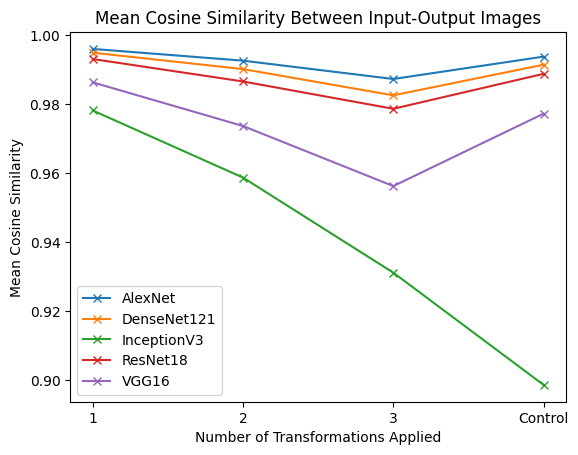

In [91]:
for k, v in plotdict.items():
    # plt.scatter([1, 2, 3], v, label=k, marker='o')
    plt.plot([0, 1, 2, 3], v, label=k, linestyle='-', marker='x')

plt.xlabel("Number of Transformations Applied")
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity Between Input-Output Images")
# plt.ylim(0.75, 1)
plt.xticks([0, 1, 2, 3], ['1', '2', '3', 'Control'])
plt.legend(loc='lower left')
plt.show()